# HW#01: Physics-Informed Neural Networks Assignment
### CE397 and CSE393: Scientific Machine Learning
#### Qianqian Tong, qt737

### 1. 1D Steady-State Heat Equation

Given one-dimensional steady-state heat conduction equation:

$$
\frac{d^2 T}{dx^2} + \frac{q(x)}{\kappa} = 0, \quad x \in [0,1]
$$

Boundary conditions:

$$
T(0) = 0, \quad T(1) = 0
$$

Parameters:
Thermal diffusivity: $\kappa = 0.5$
Heat source term: $q(x) = 15x - 2$

#### a) PINN Design
- Input: spatial coordinate $x$
- Hidden layers: 3 layers, 32 neurons per layer
- Activation: `tanh` (smooth, differentiable)
- Output: temperature $T(x)$

#### b) Physical Loss Function
The PINN loss consists of two parts:

**Data loss**


**PDE loss** (enforcing the heat equation at collocation points):

$$
L_{\text{physics}} = \frac{1}{N_f} \sum_{i=1}^{N_f} \left( \frac{d^2 T_\theta(x_i)}{dx^2} + \frac{q(x_i)}{\kappa} \right)^2
$$

#### c) Boundary Loss Function
**Boundary condition loss**:

$$
L_{\text{BC}} = |T_\theta(0)|^2 + |T_\theta(1)|^2
$$


#### d) Training Network
- Collocation points: $N_f = 100$, uniformly sampled in $[0,1]$
- Optimizer: Adam, learning rate $10^{-3}$
- Epochs: 10,000


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [5]:
class PINN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, output_size=1, num_layers=3):
        super(PINN, self).__init__()
        layers = []
        # input layer
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.Tanh())
        # hidden layers
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        # output layer
        layers.append(nn.Linear(hidden_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# PDE residual loss for: T''(x) + (15x - 2)/0.5 = 0
def pde_loss(model, x_interior, kappa=0.5):
    x_interior.requires_grad_(True)
    t = model(x_interior)
    # first derivative
    dt_dx = torch.autograd.grad(t, x_interior, torch.ones_like(t), create_graph=True)[0]
    # second derivative
    d2t_dx2 = torch.autograd.grad(dt_dx, x_interior, torch.ones_like(dt_dx), create_graph=True)[0]
    # PDE residual
    q = 15 * x_interior - 2
    residual = d2t_dx2 + q / kappa
    return torch.mean(residual**2)

# Boundary condition loss: t(0)=0, t(1)=0
def boundary_loss(model, t_boundary):
    t_boundary = model(t_boundary)
    return torch.mean(t_boundary**2)

# Training function
def train_pinn(model, optimizer, epochs, x_interior, x_boundary, lambda_bc=1.0, kappa=0.5):
    history = {"pde": [], "bc": [], "total": []}
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss_pde = pde_loss(model, x_interior, kappa)
        loss_bc = boundary_loss(model, x_boundary)
        loss = loss_pde + lambda_bc * loss_bc
        loss.backward()
        optimizer.step()
        # store
        history["pde"].append(loss_pde.item())
        history["bc"].append(loss_bc.item())
        history["total"].append(loss.item())
        if (epoch+1) % 1000 == 0:
            print(f"Epoch {epoch+1}: PDE={loss_pde.item():.4e}, BC={loss_bc.item():.4e}, Total={loss.item():.4e}")
    return history

# Setup collocation and boundary points
N_f = 100
x_interior = torch.linspace(0, 1, N_f).view(-1,1)
x_boundary = torch.tensor([[0.0],[1.0]])

# Initialize model and optimizer
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train
history = train_pinn(model, optimizer, epochs=10000, x_interior=x_interior, x_boundary=x_boundary, lambda_bc=1.0)

# Evaluate solution
t_test = np.linspace(0, 1, 200).reshape(-1,1)
t_tensor = torch.tensor(t_test, dtype=torch.float32)
t_pred = model(t_tensor).detach().numpy()

Epoch 1000: PDE=1.8696e-02, BC=1.7176e-03, Total=2.0414e-02
Epoch 2000: PDE=1.7203e-03, BC=2.7017e-05, Total=1.7473e-03
Epoch 3000: PDE=7.4804e-04, BC=3.4516e-06, Total=7.5149e-04
Epoch 4000: PDE=4.2286e-04, BC=1.2055e-06, Total=4.2406e-04
Epoch 5000: PDE=2.1361e-04, BC=4.0050e-07, Total=2.1401e-04
Epoch 6000: PDE=9.3654e-05, BC=9.8265e-08, Total=9.3753e-05
Epoch 7000: PDE=5.4078e-05, BC=2.7893e-08, Total=5.4106e-05
Epoch 8000: PDE=1.0625e-03, BC=1.2506e-06, Total=1.0637e-03
Epoch 9000: PDE=2.9260e-05, BC=4.8226e-09, Total=2.9265e-05
Epoch 10000: PDE=2.2124e-05, BC=3.1846e-09, Total=2.2127e-05


#### e) Analytical Solution
The PDE can be integrated twice:

$$
\frac{d^2 T}{dx^2} = -\frac{q(x)}{\kappa} = -30x + 4
$$

$$
\frac{dT}{dx} = -15x^2 + 4x + C_1
$$

$$
T(x) = -5x^3 + 2x^2 + C_1 x + C_2
$$

Applying boundary conditions:

$$
C_2 = 0, \quad C_1 = 3
$$

Final solution:

$$
T(x) = -5x^3 + 2x^2 + 3x
$$


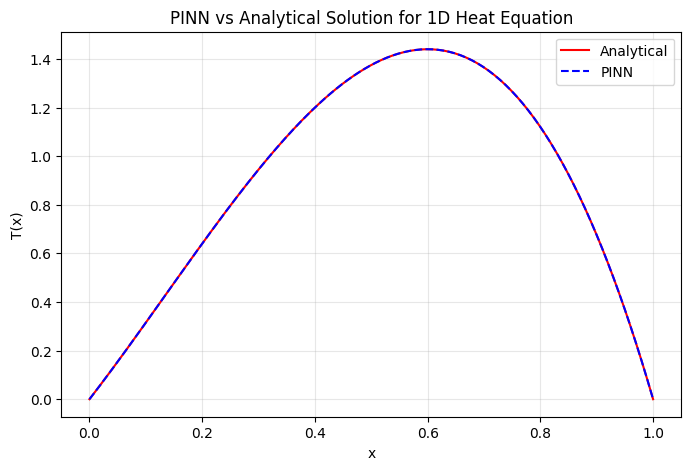

Relative L2 Error: 3.46549235824537e-05


In [6]:
# Analytical solution: T(x) = -5x^3 + 2x^2 + 3x
t_exact = -5*t_test**3 + 2*t_test**2 + 3*t_test

# Plot comparison
plt.figure(figsize=(8,5))
plt.plot(t_test, t_exact, 'r-', label="Analytical")
plt.plot(t_test, t_pred, 'b--', label="PINN")
plt.xlabel("x")
plt.ylabel("T(x)")
plt.title("PINN vs Analytical Solution for 1D Heat Equation")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Relative L2 error
error_l2 = np.linalg.norm(t_pred - t_exact, 2) / np.linalg.norm(t_exact, 2)
print("Relative L2 Error:", error_l2)

#### 2. Loss Function Design

Investigate adaptive loss weighting and fix-weighted formulations of the loss function:
1. Fixed weights
2. adaptive (learnable α, β)

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


class PINN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, output_size=1, num_layers=3):
        super(PINN, self).__init__()
        layers = [nn.Linear(input_size, hidden_size), nn.Tanh()]
        for _ in range(num_layers - 2):
            layers += [nn.Linear(hidden_size, hidden_size), nn.Tanh()]
        layers += [nn.Linear(hidden_size, output_size)]
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


def pde_loss(model, x_interior, kappa=0.5):
    """T''(x) + (15x - 2)/kappa = 0"""
    x_interior.requires_grad_(True)
    T = model(x_interior)
    dT_dx = torch.autograd.grad(T, x_interior, torch.ones_like(T), create_graph=True)[0]
    d2T_dx2 = torch.autograd.grad(dT_dx, x_interior, torch.ones_like(dT_dx), create_graph=True)[0]
    q = 15 * x_interior - 2
    residual = d2T_dx2 + q / kappa
    return torch.mean(residual**2)

def boundary_loss(model, x_boundary):
    """T(0)=0, T(1)=0"""
    T_boundary = model(x_boundary)
    return torch.mean(T_boundary**2)


def train_fixed(model, optimizer, epochs, x_interior, x_boundary):
    hist = {"pde": [], "bc": [], "total": []}
    for epoch in range(epochs):
        optimizer.zero_grad()
        L_pde = pde_loss(model, x_interior)
        L_bc = boundary_loss(model, x_boundary)
        L_total = L_pde + L_bc
        L_total.backward()
        optimizer.step()
        hist["pde"].append(L_pde.item())
        hist["bc"].append(L_bc.item())
        hist["total"].append(L_total.item())
    return hist


def train_adaptive_learnable(model, epochs, x_interior, x_boundary):
    """Adaptive-weight PINN with learnable α, β"""
    theta_alpha = torch.nn.Parameter(torch.tensor(0.0))  # log(alpha)
    theta_beta = torch.nn.Parameter(torch.tensor(0.0))   # log(beta)
    params = list(model.parameters()) + [theta_alpha, theta_beta]
    optimizer = optim.Adam(params, lr=1e-3)

    hist = {"pde": [], "bc": [], "total": [], "alpha": [], "beta": []}
    for epoch in range(epochs):
        optimizer.zero_grad()
        L_pde = pde_loss(model, x_interior)
        L_bc = boundary_loss(model, x_boundary)

        alpha = torch.exp(theta_alpha)
        beta = torch.exp(theta_beta)
        L_total = alpha * L_bc + beta * L_pde

        L_total.backward()
        optimizer.step()

        hist["pde"].append(L_pde.item())
        hist["bc"].append(L_bc.item())
        hist["total"].append(L_total.item())
        hist["alpha"].append(alpha.item())
        hist["beta"].append(beta.item())

        if (epoch+1) % 2000 == 0:
            print(f"Epoch {epoch+1}: α={alpha.item():.2f}, β={beta.item():.2f}, Loss={L_total.item():.2e}")

    return hist


N_interior = 100
x_interior = torch.linspace(0, 1, N_interior).view(-1,1)
x_boundary = torch.tensor([[0.0],[1.0]])
epochs = 10000

# (a) Fixed weights
model_fixed = PINN()
opt_fixed = optim.Adam(model_fixed.parameters(), lr=1e-3)
hist_fixed = train_fixed(model_fixed, opt_fixed, epochs, x_interior, x_boundary)

# (b) Adaptive weights (learnable)
model_adapt = PINN()
hist_adapt = train_adaptive_learnable(model_adapt, epochs, x_interior, x_boundary)

# Evaluation
x_test = np.linspace(0, 1, 200).reshape(-1,1)
x_tensor = torch.tensor(x_test, dtype=torch.float32)
T_exact = -5*x_test**3 + 2*x_test**2 + 3*x_test

T_fixed = model_fixed(x_tensor).detach().numpy()
T_adapt = model_adapt(x_tensor).detach().numpy()

# Relative L2 Errors
err_fixed = np.linalg.norm(T_fixed - T_exact, 2) / np.linalg.norm(T_exact, 2)
err_adapt = np.linalg.norm(T_adapt - T_exact, 2) / np.linalg.norm(T_exact, 2)
print("Relative L2 Error (Fixed):", err_fixed)
print("Relative L2 Error (Adaptive):", err_adapt)

Epoch 2000: α=0.68, β=0.90, Loss=5.86e-03
Epoch 4000: α=0.68, β=0.90, Loss=4.35e-04
Epoch 6000: α=0.68, β=0.90, Loss=1.11e-04
Epoch 8000: α=0.68, β=0.90, Loss=4.80e-05
Epoch 10000: α=0.68, β=0.90, Loss=3.72e-05
Relative L2 Error (Fixed): 7.146880921691803e-05
Relative L2 Error (Adaptive): 5.290404908402689e-05


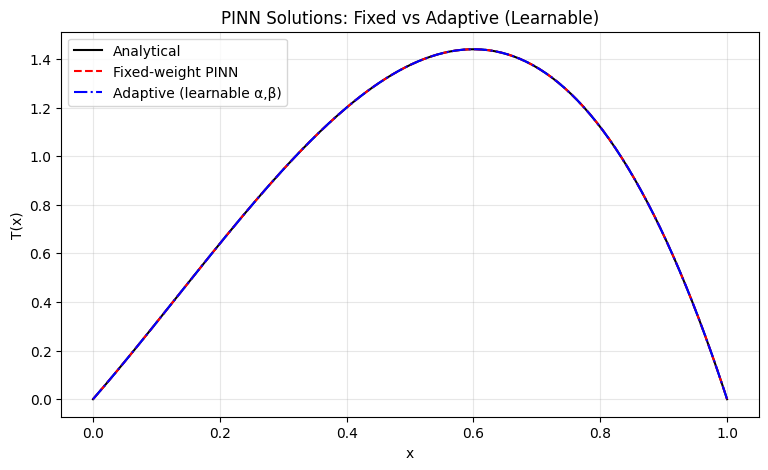

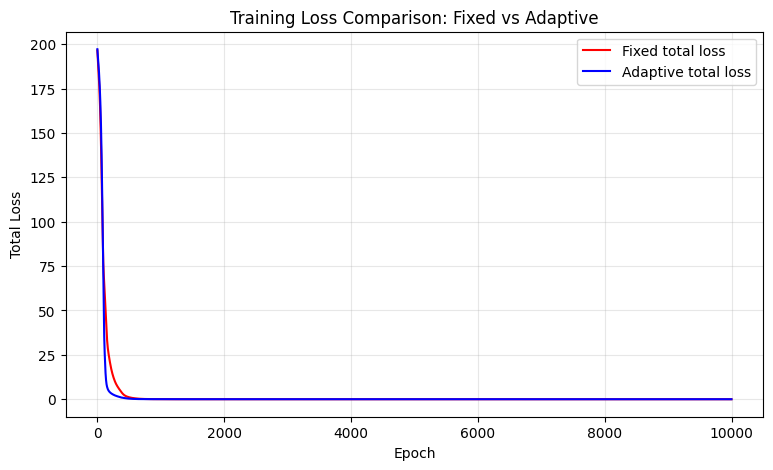

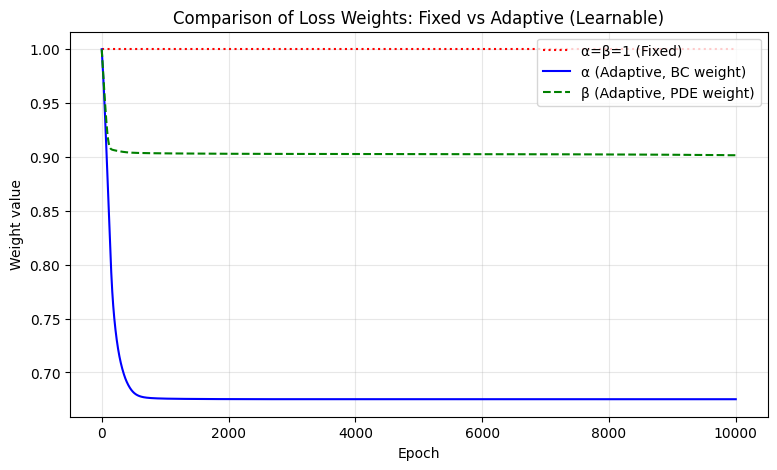

In [17]:
# (1) Solution comparison
plt.figure(figsize=(9,5))
plt.plot(x_test, T_exact, 'k-', label="Analytical")
plt.plot(x_test, T_fixed, 'r--', label="Fixed-weight PINN")
plt.plot(x_test, T_adapt, 'b-.', label="Adaptive (learnable α,β)")
plt.xlabel("x")
plt.ylabel("T(x)")
plt.title("PINN Solutions: Fixed vs Adaptive (Learnable)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# (2) Training loss comparison
plt.figure(figsize=(9,5))
plt.plot(hist_fixed["total"], 'r-', label="Fixed total loss")
plt.plot(hist_adapt["total"], 'b-', label="Adaptive total loss")
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.title("Training Loss Comparison: Fixed vs Adaptive")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# (3) α and β evolution: Fixed vs Adaptive
plt.figure(figsize=(9,5))

# Fixed (constant 1)
plt.hlines(1.0, 0, len(hist_adapt["alpha"]), colors='r', linestyles='dotted', label="α=β=1 (Fixed)")

# Adaptive (learnable)
plt.plot(hist_adapt["alpha"], 'b-', label="α (Adaptive, BC weight)")
plt.plot(hist_adapt["beta"], 'g--', label="β (Adaptive, PDE weight)")

plt.xlabel("Epoch")
plt.ylabel("Weight value")
plt.title("Comparison of Loss Weights: Fixed vs Adaptive (Learnable)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### 4. Data-Driven Cross-Section Identification
We consider the static bar equation where the displacement field $u(x)$ is known, but the cross-sectional properties $EA(x)$ is unknown and identified:

$$
\frac{d}{dx} \Big( EA(x)\frac{du}{dx} \Big) + p(x) = 0, \quad x \in [0,1]
$$

Given:
- Displacement field:
  $$
  u(x) = \sin(2\pi x)
  $$
- Distributed load:
  $$
  p(x) = -2(3x^2 - 2x)\pi \cos(2\pi x) + 4(x^3 - x^2 + 1)\pi^2 \sin(2\pi x)
  $$
- Domain: $x \in [0,1]$
- Boundary conditions:
  $$
  u(0) = u(1) = 0
  $$

Analytical solution:
$$
EA(x) = x^3 - x^2 + 1
$$

#### (a) PINN Architecture
Design a physics-informed neural network (PINN) to identify $EA(x)$.
- **Inputs**: 2 (spatial coordinate $x$, displacement $u(x)$)
- **Hidden layers**: 3 fully-connected layers with 20 neurons each
- **Activation**: hyperbolic tangent (tanh)
- **Output**: 1 (stiffness $EA(x)$)


#### (b) Loss Function
The governing equation is:

$$
\frac{d}{dx}\Big(EA(x)u'(x)\Big) + p(x) = 0
$$

Define the residual:

$$
R(x) = \frac{d}{dx}\Big(EA_\theta(x)\cdot u'(x)\Big) + p(x)
$$

Physics-informed loss:

$$
L_{\text{physics}} = \frac{1}{N}\sum_{i=1}^N R(x_i)^2
$$

Since $u(x)$ is given and already satisfies boundary conditions in the context of inverse problem, no boundary loss is required.


#### (c) Training Setup
- Number of collocation points: $N = 100$, uniformly sampled in $[0,1]$
- Optimizer: Adam with learning rate $10^{-3}$
- Epochs: 5000

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# 1. Define the known displacement u(x) and distributed load p(x)
# --------------------------
def u(x):
    return torch.sin(2 * np.pi * x)

def du_dx(x):
    return torch.autograd.grad(u(x), x, torch.ones_like(x), create_graph=True)[0]

def d2u_dx2(x):
    return torch.autograd.grad(du_dx(x), x, torch.ones_like(x), create_graph=True)[0]

def p(x):
    return -2*(3*x**2 - 2*x)*np.pi*torch.cos(2*np.pi*x) + \
           4*(x**3 - x**2 + 1)*(np.pi**2)*torch.sin(2*np.pi*x)

# --------------------------
# 2. Neural Network for EA(x)
# --------------------------
class PINN_EA(nn.Module):
    def __init__(self, input_size=2, hidden_size=20, output_size=1, num_layers=3):
        super(PINN_EA, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.Tanh())
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x, u_val):
        inp = torch.cat([x, u_val], dim=1)  # input = [x, u(x)]
        return self.network(inp)            # output = EA(x)

# --------------------------
# 3. Physics-Informed Loss Function
# --------------------------
def physics_loss(model, x_colloc):
    x_colloc.requires_grad_(True)

    u_val = u(x_colloc)
    du = torch.autograd.grad(u_val, x_colloc, torch.ones_like(u_val), create_graph=True)[0]

    EA_pred = model(x_colloc, u_val)  # predicted stiffness
    EA_du = EA_pred * du

    dEA_du_dx = torch.autograd.grad(EA_du, x_colloc, torch.ones_like(EA_du), create_graph=True)[0]

    residual = dEA_du_dx + p(x_colloc)
    return torch.mean(residual**2)

# --------------------------
# 4. Training
# --------------------------
# Collocation points
N_colloc = 100
x_colloc = torch.linspace(0, 1, N_colloc).view(-1,1)

# Model + optimizer
model = PINN_EA()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 5000
history = []

for epoch in range(epochs):
    optimizer.zero_grad()
    loss = physics_loss(model, x_colloc)
    loss.backward()
    optimizer.step()
    history.append(loss.item())
    if (epoch+1) % 1000 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss = {loss.item():.6e}")

Epoch 1000/5000, Loss = 3.428032e+00
Epoch 2000/5000, Loss = 2.659959e-02
Epoch 3000/5000, Loss = 5.232674e-03
Epoch 4000/5000, Loss = 3.115142e-03
Epoch 5000/5000, Loss = 1.979600e-03


#### (d) Evaluation
Compare the identified stiffness function $EA(x)$ with the analytical solution:

$$
EA(x) = x^3 - x^2 + 1
$$

We expect the PINN-predicted curve to match closely with the analytical solution, and the relative $L^2$ error can be used as a performance metric.

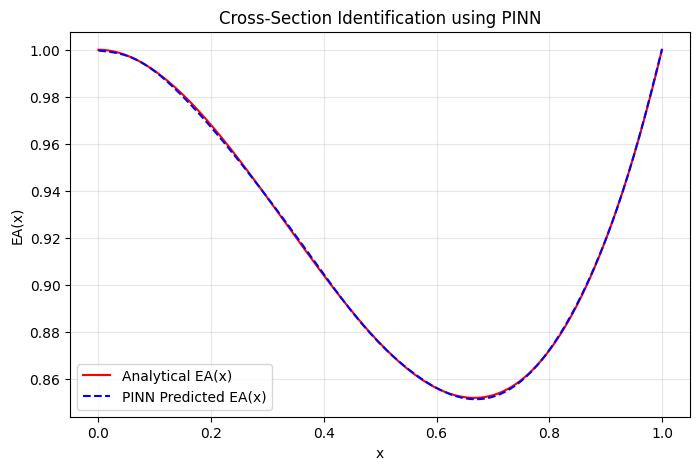

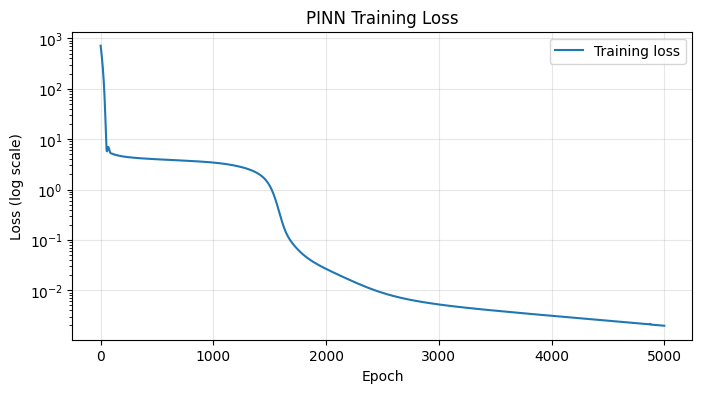

Relative L2 Error: 0.0004825400515389822


In [20]:
# --------------------------
# 5. Evaluation
# --------------------------
x_test = np.linspace(0, 1, 200).reshape(-1,1)
x_tensor = torch.tensor(x_test, dtype=torch.float32, requires_grad=True)
u_test = u(x_tensor)

EA_pred = model(x_tensor, u_test).detach().numpy()
EA_exact = x_test**3 - x_test**2 + 1

# Plot identified vs analytical EA(x)
plt.figure(figsize=(8,5))
plt.plot(x_test, EA_exact, 'r-', label="Analytical EA(x)")
plt.plot(x_test, EA_pred, 'b--', label="PINN Predicted EA(x)")
plt.xlabel("x")
plt.ylabel("EA(x)")
plt.title("Cross-Section Identification using PINN")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot training loss
plt.figure(figsize=(8,4))
plt.semilogy(history, label="Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.title("PINN Training Loss")
plt.show()

# Relative L2 error
error_l2 = np.linalg.norm(EA_pred - EA_exact, 2) / np.linalg.norm(EA_exact, 2)
print("Relative L2 Error:", error_l2)

#### (e) Effect of Noisy Measurements
Study the influence of noise in the displacement measurements by adding Gaussian noise with
a standard deviation of 0.01.

To simulate experimental conditions, add Gaussian noise to the displacement field:

$$
u_{\text{noisy}}(x) = u(x) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.01^2)
$$

Compare the identified $EA(x)$ with and without noise.
- Noisy displacement data will degrade the accuracy.
- However, due to the physics constraints in the loss function, PINNs remain more robust compared to purely data-driven regression.

[Noise=0.0] Epoch 1000: Loss=2.550062e+00
[Noise=0.0] Epoch 2000: Loss=9.589580e-02
[Noise=0.0] Epoch 3000: Loss=3.083540e-02
[Noise=0.0] Epoch 4000: Loss=1.963008e-02
[Noise=0.0] Epoch 5000: Loss=1.253436e-02
[Noise=0.01] Epoch 1000: Loss=4.133004e+00
[Noise=0.01] Epoch 2000: Loss=3.086389e+00
[Noise=0.01] Epoch 3000: Loss=4.325707e-02
[Noise=0.01] Epoch 4000: Loss=1.974178e-02
[Noise=0.01] Epoch 5000: Loss=1.175506e-02


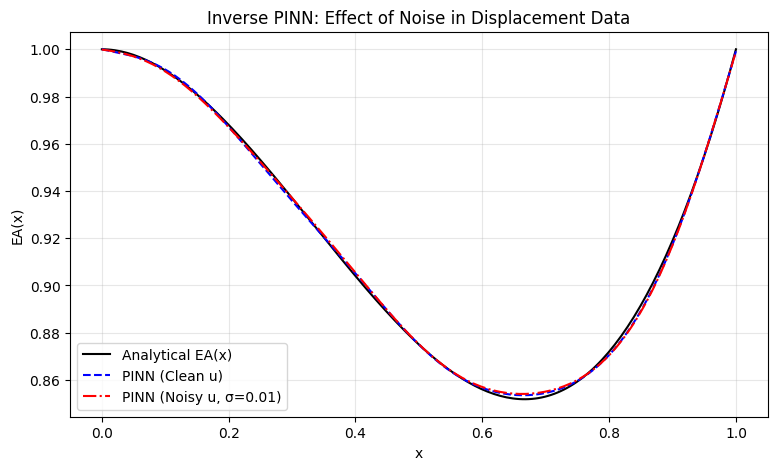

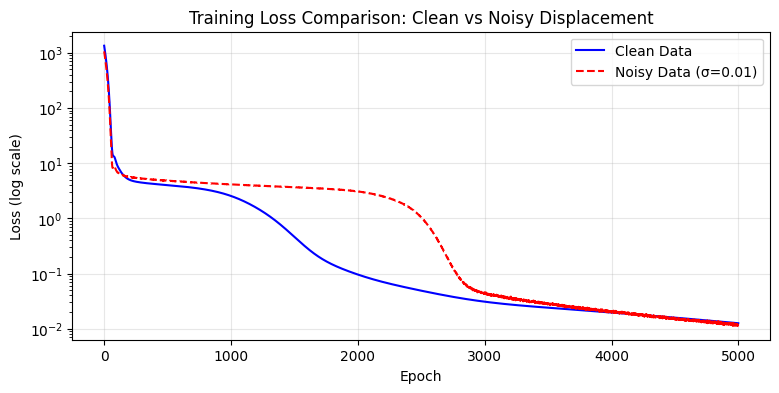

Relative L2 Error (Clean) = 1.1598e-03
Relative L2 Error (Noisy, σ=0.01) = 1.3374e-03


In [21]:
# --------------------------
# 1. Define known displacement u(x) and load p(x)
# --------------------------
def u(x):
    return torch.sin(2 * np.pi * x)

def p(x):
    return -2*(3*x**2 - 2*x)*np.pi*torch.cos(2*np.pi*x) + \
           4*(x**3 - x**2 + 1)*(np.pi**2)*torch.sin(2*np.pi*x)

# --------------------------
# 2. PINN model for EA(x)
# --------------------------
class PINN_EA(nn.Module):
    def __init__(self, input_size=2, hidden_size=20, output_size=1, num_layers=3):
        super(PINN_EA, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.Tanh())
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x, u_val):
        inp = torch.cat([x, u_val], dim=1)
        return self.network(inp)   # predicted EA(x)

# --------------------------
# 3. Physics loss (with optional noisy u)
# --------------------------
def physics_loss(model, x_colloc, u_func, p_func, noise_std=0.0):
    x_colloc.requires_grad_(True)

    # Compute u(x) with optional Gaussian noise
    u_val = u_func(x_colloc)
    if noise_std > 0.0:
        noise = noise_std * torch.randn_like(u_val)
        u_val = u_val + noise

    du = torch.autograd.grad(u_val, x_colloc, torch.ones_like(u_val), create_graph=True)[0]

    EA_pred = model(x_colloc, u_val)
    EA_du = EA_pred * du

    dEA_du_dx = torch.autograd.grad(EA_du, x_colloc, torch.ones_like(EA_du), create_graph=True)[0]
    residual = dEA_du_dx + p_func(x_colloc)
    return torch.mean(residual**2)

# --------------------------
# 4. Training routine
# --------------------------
def train_inverse_pinn(noise_std=0.0, epochs=5000, lr=1e-3):
    model = PINN_EA()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    x_colloc = torch.linspace(0, 1, 100).view(-1,1)
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = physics_loss(model, x_colloc, u, p, noise_std)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if (epoch+1) % 1000 == 0:
            print(f"[Noise={noise_std}] Epoch {epoch+1}: Loss={loss.item():.6e}")

    return model, np.array(losses)

# --------------------------
# 5. Train: Noise-free vs Noisy
# --------------------------
model_clean, loss_clean = train_inverse_pinn(noise_std=0.0)
model_noisy, loss_noisy = train_inverse_pinn(noise_std=0.01)

# --------------------------
# 6. Evaluation
# --------------------------
x_test = np.linspace(0, 1, 200).reshape(-1,1)
x_tensor = torch.tensor(x_test, dtype=torch.float32, requires_grad=True)
u_test = u(x_tensor)

EA_true = x_test**3 - x_test**2 + 1
EA_clean = model_clean(x_tensor, u_test).detach().numpy()
EA_noisy = model_noisy(x_tensor, u_test).detach().numpy()

# --------------------------
# 7. Visualization
# --------------------------
plt.figure(figsize=(9,5))
plt.plot(x_test, EA_true, 'k-', label='Analytical EA(x)')
plt.plot(x_test, EA_clean, 'b--', label='PINN (Clean u)')
plt.plot(x_test, EA_noisy, 'r-.', label='PINN (Noisy u, σ=0.01)')
plt.xlabel("x")
plt.ylabel("EA(x)")
plt.title("Inverse PINN: Effect of Noise in Displacement Data")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Loss curves
plt.figure(figsize=(9,4))
plt.semilogy(loss_clean, 'b-', label="Clean Data")
plt.semilogy(loss_noisy, 'r--', label="Noisy Data (σ=0.01)")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.title("Training Loss Comparison: Clean vs Noisy Displacement")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --------------------------
# 8. Quantitative error
# --------------------------
err_clean = np.linalg.norm(EA_clean - EA_true, 2) / np.linalg.norm(EA_true, 2)
err_noisy = np.linalg.norm(EA_noisy - EA_true, 2) / np.linalg.norm(EA_true, 2)
print(f"Relative L2 Error (Clean) = {err_clean:.4e}")
print(f"Relative L2 Error (Noisy, σ=0.01) = {err_noisy:.4e}")